In [0]:

import sys
from sklearn.model_selection import train_test_split
import tensorflow as tf
assert tf.__version__ >= "2.0"
# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)


In [2]:
train = pd.read_csv('train.csv')
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
train.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [0]:
X,y = train.text,train.target
X_train,X_val,y_train,y_val = train_test_split(X,y,
                                               test_size=0.2,stratify=y,random_state=42)

In [0]:
train_size = X_train.shape[0]
val_size = X_val.shape[0]

## Building LSTM and embedding based classifier

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val))

In [0]:
def regexprocessing(X_batch,y_batch=None):
  X_batch = tf.strings.substr(X_batch,0,100)
  X_batch = tf.strings.regex_replace(X_batch,r'https?://\S+|www\.\S+',b" ")
  X_batch = tf.strings.regex_replace(X_batch,r'<.*?>',b" ")
  X_batch = tf.strings.regex_replace(X_batch,r'[^\w\s]',b"")
  X_batch = tf.strings.split(X_batch)
  if y_batch !=None:
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch
  else:
    return X_batch.to_tensor(default_value=b"<pad>") 

In [0]:
for X_batch, y_batch in dataset.batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: Trauma can happen anywhere -- school home etc. -- at any time. Learn the ABC's of trauma and how to parent... Û_ http://t.co/fMj8MXJY8a ...
Label: 1 = Positive

Review: @breakingnewslh @bree_mars watch cnn's the seventies terrorism episode. Iran has always hated the U.S. They want us obliterated. ...
Label: 1 = Positive



In [0]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in dataset.batch(32).map(regexprocessing):
    for review in X_batch:
      vocabulary.update(list(review.numpy()))

In [0]:
vocabulary.most_common()[:3]

[(b'<pad>', 54000), (b'the', 2109), (b'a', 1535)]

In [0]:
len(vocabulary)

19360

In [0]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [0]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [0]:
# embedding_dict={}
# with open('glove.6B.100d.txt','r') as f:
#     for line in f:
#         values=line.split()
#         word = values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embedding_dict[word]=vectors


In [0]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch
batch_size = 32
train_set = dataset.shuffle(5000).repeat().batch(batch_size).map(regexprocessing)
train_set = train_set.map(encode_words).prefetch(1)
val_set = val_dataset.shuffle(5000).repeat().batch(batch_size).map(regexprocessing)
val_set = val_set.map(encode_words).prefetch(1)

In [0]:
for X_batch, y_batch in train_set.take(5):
    print(X_batch.shape,y_batch.shape)
    #print(y_batch)

(32, 21) (32,)
(32, 21) (32,)
(32, 20) (32,)
(32, 22) (32,)
(32, 21) (32,)


In [0]:
embed_size = 128
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size+num_oov_buckets,embed_size,
                           mask_zero = True,
                           input_shape=[None]),
        tf.keras.layers.LSTM(128,return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(1,activation='sigmoid')
])
num_epochs = 5
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set,steps_per_epoch = train_size// batch_size,epochs = num_epochs,
                    validation_data=val_set, validation_steps = val_size //batch_size)

Epoch 1/5
214/214 [==============================] - 7s 31ms/step - loss: 0.5224 - accuracy: 0.7453 - val_loss: 0.4692 - val_accuracy: 0.7853
Epoch 2/5
214/214 [==============================] - 5s 22ms/step - loss: 0.2959 - accuracy: 0.8846 - val_loss: 0.5698 - val_accuracy: 0.7568
Epoch 3/5
214/214 [==============================] - 5s 23ms/step - loss: 0.1795 - accuracy: 0.9368 - val_loss: 0.6913 - val_accuracy: 0.7364
Epoch 4/5
214/214 [==============================] - 5s 23ms/step - loss: 0.1125 - accuracy: 0.9648 - val_loss: 0.9281 - val_accuracy: 0.7486
Epoch 5/5
214/214 [==============================] - 5s 24ms/step - loss: 0.0705 - accuracy: 0.9749 - val_loss: 0.9734 - val_accuracy: 0.7310


Text(0, 0.5, 'Accuracy')

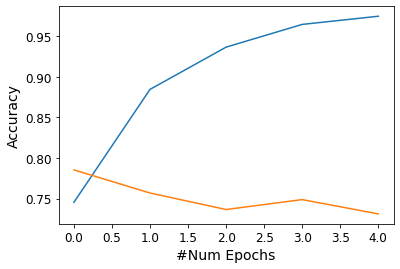

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('#Num Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'loss')

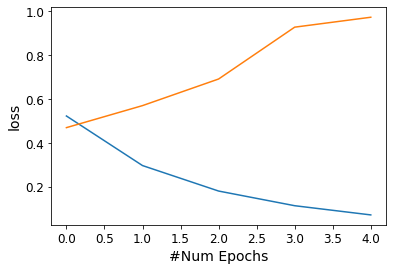

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('#Num Epochs')
plt.ylabel('loss')

##USING BERT from Tensorflow Hub

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [9]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 4.9MB/s 


In [0]:
import tensorflow_hub as hub
import tokenization
import re
import string

In [0]:
url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1" 

In [0]:
bert_layer = hub.KerasLayer(url)

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
def regexprocessing(text):
  max_len = 50
  text = remove_URL(text)
  text = remove_html(text)
  text = remove_punct(text)
  return text

def bert_encoding(texts,tokenizer,max_len=150):
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in texts:
    text = tokenizer.tokenize(text)
    text = text[:max_len-2]
    ip_sequence = ["[CLS]"] + text + ["[SEP]"]
    pad_len = max_len - len(ip_sequence)
    tokens = tokenizer.convert_tokens_to_ids(ip_sequence)
    tokens += [0] * pad_len
    pad_masks = [1] * len(ip_sequence) + [0] * pad_len
    segment_ids = [0] * max_len

    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)
  return np.array(all_tokens),np.array(all_masks),np.array(all_segments)


In [0]:
train_bert_encoded = bert_encoding(X_train.apply(regexprocessing).values,tokenizer,50)
val_bert_encoded = bert_encoding(X_val.apply(regexprocessing).values,tokenizer,50)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((train_bert_encoded,y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((val_bert_encoded,y_val))

In [0]:
def build_model(bert_layer,max_len=150):
  input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
  input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
  segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)

  _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)#sequence_output[:, 0, :]

  out = tf.keras.layers.Dense(1, activation='sigmoid')(clf_output)
  model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
   
  return model


In [21]:
model = build_model(bert_layer,50)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_4[0][0]                    
                                                                 input_5[0][0]                

In [0]:
batch_size = 32
train_set = dataset.shuffle(1000).repeat().batch(32).prefetch(1)
val_set= val_dataset.shuffle(1000).repeat().batch(32).prefetch(1)

In [23]:
num_epochs = 6
history = model.fit(train_set,steps_per_epoch = train_size// batch_size,epochs = num_epochs,
                    validation_data=val_set, validation_steps = val_size //batch_size)

Epoch 1/6
190/190 [==============================] - 48s 252ms/step - loss: 0.5182 - accuracy: 0.7507 - val_loss: 0.4447 - val_accuracy: 0.8085
Epoch 2/6
190/190 [==============================] - 45s 239ms/step - loss: 0.4402 - accuracy: 0.8058 - val_loss: 0.4215 - val_accuracy: 0.8231
Epoch 3/6
190/190 [==============================] - 46s 239ms/step - loss: 0.4227 - accuracy: 0.8161 - val_loss: 0.4099 - val_accuracy: 0.8278
Epoch 4/6
190/190 [==============================] - 45s 239ms/step - loss: 0.4117 - accuracy: 0.8224 - val_loss: 0.4081 - val_accuracy: 0.8331
Epoch 5/6
190/190 [==============================] - 45s 239ms/step - loss: 0.4074 - accuracy: 0.8219 - val_loss: 0.4048 - val_accuracy: 0.8351
Epoch 6/6
190/190 [==============================] - 45s 239ms/step - loss: 0.3995 - accuracy: 0.8281 - val_loss: 0.4077 - val_accuracy: 0.8285


In [0]:
test_data = pd.read_csv('test.csv')

In [0]:
X_test = test_data.text

In [0]:
test_bert_encoded = bert_encoding(X_test.apply(regexprocessing).values,tokenizer,50)

In [0]:
test_pred = model.predict(test_bert_encoded)

In [28]:
test_pred

array([[0.31723318],
       [0.9850427 ],
       [0.7980041 ],
       ...,
       [0.9943844 ],
       [0.7365942 ],
       [0.7862955 ]], dtype=float32)

In [0]:
submission = pd.read_csv('sample_submission.csv')

In [0]:
submission.target = test_pred.round().astype(int)

In [0]:
submission.to_csv('submission.csv', index=False)

In [32]:
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
